In [1]:
from numpy import exp, log, sqrt, empty
import numpy as np
from scipy import constants as sci, integrate as ode, optimize as root

In [2]:
import pint
si = pint.UnitRegistry()

In [3]:
import mendeleev as pt
def awgh(x):
    return x.atomic_weight * si.gram / si.mole

In [4]:
# constants
class phys:
    g     = sci.g * si.metre / si.second**2
    pi    = sci.pi
    R_str = sci.R * si.joule / si.kelvin / si.mole       


    c_pd  = 1005 * si.joule / si.kilogram / si.kelvin
    c_pv  = 1850 * si.joule / si.kilogram / si.kelvin
    c_pw  = 4218 * si.joule / si.kilogram / si.kelvin
    
    p_tri = 611.73  * si.pascal
    T_tri = 273.16  * si.kelvin
    l_tri = 2.5e6   * si.joule / si.kilogram
    
    sgm   = 0.072   * si.joule / si.metre**2
    rho_w = 1 * si.kilograms / si.litres
    
    Md    = 0.78 * awgh(pt.N) * 2 + 0.21 * awgh(pt.O) * 2 + 0.01 * awgh(pt.Ar)
    Mv    = awgh(pt.O) + awgh(pt.H) * 2
    eps   = Mv / Md
    Rd    = R_str / Md
    Rv    = R_str / Mv
    D0    = 2.26e-5 * si.metre**2 / si.second
    K0    = 2.4e-2  * si.joules / si.metres / si.seconds / si.kelvins
    
    
# pressure deriv. (hydrostatic) 
phys.dp_dt = lambda p, T, w, q: -(p / phys.R(q) / T) * phys.g * w


# temperature deriv. (adiabatic)
phys.dT_dt = lambda T,  p, dp_dt, q, dq_dt : (T * phys.R(q) / p * dp_dt - phys.lv(T)*dq_dt ) / phys.c_p(q)


# specific humidity deriv. (monodisperse)
# phys.dq_dt = lambda n, r, dr_dt: -4/3 * sci.pi * n * 3 * r**2 * dr_dt * phys.rho_w
phys.dq_dt = lambda n, r, dr_dt: -4/3 * sci.pi * n * 3 * np.sum(r**2 * dr_dt) * phys.rho_w

# funkcja lambda wystarczy zdefiniowaÄ‡ jednÄ… i odwoÅ‚ywaÄ‡ siÄ™ do niej
phys.dr_dt = lambda r, T, RH, kp, rd: 1/r * (RH - 1 - phys.A(T)/r + phys.B(kp,rd)/r**3) / (phys.Fd(T)+phys.Fk(T,phys.lv(T)))

# RH from specific humidity, temperature and pressure
phys.RH = lambda T, p, q: p * q / (phys.eps + q * (1 - phys.eps)) / phys.pvs(T)


#
phys.mix = lambda q, dry, wet: wet/(1/q + 1) + dry/(1 + q)
phys.c_p = lambda q: phys.mix(q, phys.c_pd, phys.c_pv)
phys.R   = lambda q: phys.mix(q, phys.Rd, phys.Rv)

# latent heat of evaporation 
phys.lv  = lambda T: phys.l_tri + (phys.c_pv - phys.c_pw) * (T - phys.T_tri)

# Maxwel-Mason coefficients
phys.Fd = lambda T: phys.rho_w * phys.Rv * T / phys.D0 / phys.pvs(T)
phys.Fk = lambda T, lv: phys.rho_w * lv / phys.K0 / T * (lv / phys.Rv / T - 1)

# Koehler curve (expressed in partial pressure)      <--- co z rd?
phys.A = lambda T: 2 * phys.sgm / phys.Rv / T / phys.rho_w
phys.B = lambda kp, rd: kp * rd**3

# critical radius
phys.r_cr = lambda kp, rd, T: sqrt(3 * kp * rd**3 / phys.A(T))


In [5]:
# integrated Clausius-Clapeyron eq.
phys.pvs = lambda T: phys.p_tri * exp(
    (phys.l_tri + (phys.c_pw - phys.c_pv) * phys.T_tri) / phys.Rv * (1 / phys.T_tri - 1/T) - 
    (phys.c_pw - phys.c_pv) / phys.Rv * log(T / phys.T_tri)
)

In [6]:
# latent heat of evaporation 
phys.lv  = lambda T: phys.l_tri + (phys.c_pv - phys.c_pw) * (T - phys.T_tri)

In [7]:
# state vector indices and units     
class indices:
    p, p_unit = 0, si.pascal
    T, T_unit = 1, si.kelvin
    q, q_unit = 2, si.dimensionless
    r_unit = si.metre
    t_unit = si.second
    
    def __init__(self, nr):
        assert(nr > 0)
        self.r = slice(3, 3 + nr)
        self.n = self.r.stop + 1

In [8]:
# parcel model with monodisperse aerosol/droplet population
class eqsys:
    def __init__(self, ix):
        self.ix = ix
        
    def __call__(self, t, y):
        ix = self.ix
        t = t * ix.t_unit
        p = y[ix.p] * ix.p_unit
        q = y[ix.q] * ix.q_unit
        T = y[ix.T] * ix.T_unit
        r = y[ix.r] * ix.r_unit

        dp_dt = phys.dp_dt(p, T, self.w(t),q)
        dr_dt = phys.dr_dt(r,T, phys.RH(T,p,q),self.kp,self.rd)
        dq_dt = phys.dq_dt(self.n,r, dr_dt)
        dT_dt = phys.dT_dt(T, p, dp_dt,q,dq_dt)
        
        dy_dt = empty(ix.n)
        dy_dt[ix.T] = (dT_dt / (ix.T_unit / ix.t_unit)).to(si.dimensionless)
        dy_dt[ix.p] = (dp_dt / (ix.p_unit / ix.t_unit)).to(si.dimensionless)
        dy_dt[ix.q] = (dq_dt / (ix.q_unit / ix.t_unit)).to(si.dimensionless)
        
        dy_dt[ix.r] = (dr_dt / (ix.r_unit / ix.t_unit)).to(si.dimensionless)
         
        return dy_dt

In [18]:
#wszystkie rd?
def parcel(*, t, T0, p0, w, q0, n, kp, rd_min, rd_max, nr, dt_max):
    ix = indices(nr)
    sys = eqsys(ix)
    sys.w = w
    sys.n = n
    sys.kp = kp # TODO: muultiple kappas
    
    sys.rd = np.linspace(
        rd_min.to(ix.r_unit).magnitude,
        rd_max.to(ix.r_unit).magnitude,
        nr
    ) * ix.r_unit# TODO: logarithmic
    
    y0 = empty(ix.n)

    y0[ix.T] = (T0/ix.T_unit).to(si.dimensionless)
    y0[ix.p] = (p0/ix.p_unit).to(si.dimensionless)
    y0[ix.q] = (q0/ix.q_unit).to(si.dimensionless)
    
    for ird, irw in enumerate(range(ix.r.start, ix.r.stop)):
        y0[irw] = root.brentq(
            lambda x: (phys.dr_dt( x * ix.r_unit, T0, phys.RH(T0,p0,q0), kp, sys.rd[ird])/(ix.r_unit/ix.t_unit)).to(si.dimensionless) + x, 
            (sys.rd[ird]/ix.r_unit).to(si.dimensionless),
            (phys.r_cr(kp, sys.rd[ird], T0)/ix.r_unit).to(si.dimensionless) 
        )   
        
    integ = ode.solve_ivp(sys, [0,t / ix.t_unit], y0, method='BDF', max_step=dt_max/ix.t_unit)
    assert integ.success
    return integ, ix

In [19]:
integ, ix = parcel(
    t = 40 * si.seconds,
    T0 = 300 * si.kelvin,
    q0 = 21 * si.grams / si.kilogram,
    p0 = 1000 * si.hectopascals,
    w = lambda t: 10* si.metre / si.second,
    n = 1000 / si.centimetre**3 / (1 * si.kilogram / si.metre**3),
    rd_min = .01 * si.micrometre,
    rd_max = .1 * si.micrometre,
    nr = 2,
    kp = 1.28,
    dt_max = 0.01 * si.second
)

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
si.setup_matplotlib()

In [21]:
T = integ.y[ix.T] * ix.T_unit
p = integ.y[ix.p] * ix.p_unit
q = integ.y[ix.q] * ix.q_unit
t = integ.t * ix.t_unit

<IPython.core.display.Javascript object>


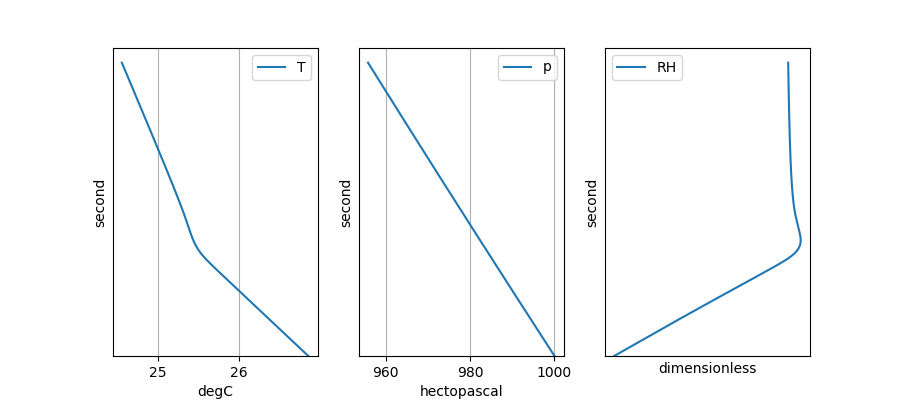

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,4))

plt.xticks([])
plt.yticks([])
ax1.set_ylim([0, 42])

ax1.plot(T, t, label="T")
ax1.grid()
ax1.legend()
ax1.xaxis.set_units(si.celsius)

ax2.plot(p, t, label="p")
ax2.grid()
ax2.legend()
ax2.xaxis.set_units(si.hectopascals)

ax3.plot(phys.RH(T, p, q), t, label="RH")
ax3.grid()
ax3.legend()

plt.show()